# Specific Test VI. SSL on Real Dataset

In [1]:
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torchvision
import torchvision.transforms.v2 as T
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import AUROC, Accuracy, ROC
from tqdm import tqdm

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

## Dataset Preprocessing

Download the dataset from Google Drive and uncompress.

In [3]:
!pip install -q gdown
!gdown 1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
!unzip -q real_hst.zip

Downloading...
From (original): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx
From (redirected): https://drive.google.com/uc?id=1aafE2nDp7S6j59sZcBIzP3FnQxVCmHCx&confirm=t&uuid=458cf0b1-1fc3-45ce-ac37-d3ad7f85a655
To: /kaggle/working/real_hst.zip
100%|██████████████████████████████████████| 80.5M/80.5M [00:01<00:00, 54.3MB/s]


Visual several images from the dataset, containing samples from no lensing (0) and lensing (1) classes.

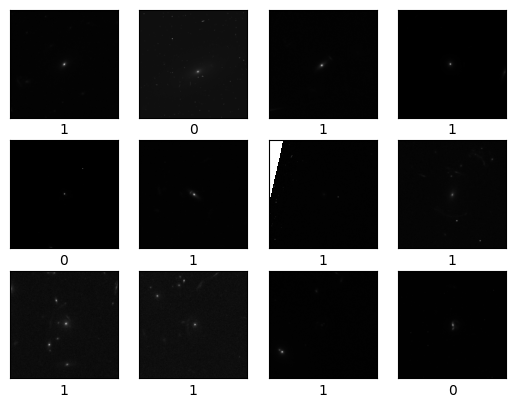

In [4]:
files = os.listdir('real_hst')
random.shuffle(files)

for i, file in enumerate(files[:12]):
    plt.subplot(3, 4, i + 1)
    plt.imshow(np.load(f'real_hst/{file}'), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(int(not file.startswith('nl')))

Note that using certain image preprocessing techniques can enhance subtle visual features.

- Left - original image
- Middle - histogram-equalized image
- Right - histogram-equalized and gaussian-blurred image

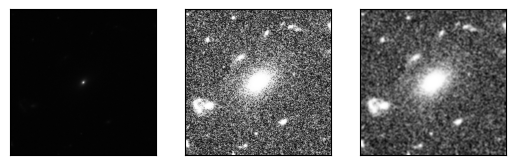

In [5]:
img = torch.from_numpy(np.load(f'real_hst/{files[0]}').astype(np.float32))
plt.subplot(1, 3, 1)
plt.imshow(img.numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
img = T.functional.equalize(img)
plt.imshow(img.numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
img = T.functional.gaussian_blur(img[None, :], kernel_size=5, sigma=5)[0]
plt.imshow(img.numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Build datasets using PyTorch interfaces.

In [6]:
class LenseImageDataset(Dataset):
    def __init__(self, root: str, transform: nn.Module = None) -> None:
        self.data = [
            (f'{root}/{file}', int(not file.startswith('nl')))
            for file in os.listdir(root)
        ]
        random.shuffle(self.data)
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Tuple[Tensor, int]:
        path, label = self.data[idx]
        image = np.load(path).astype(np.float32)
        image = torch.from_numpy(image).unsqueeze(0)
        image /= image.max()       # normalize between [0, 1]
        image = image.nan_to_num() # convert nans to zero
        if self.transform:
            image = self.transform(image)
        return image, label

## Model Training - AutoEncoder

Initialize train/validation datasets.
- Use small batch size as very few data points are available,
- Use histogram equalization to enhance image contrast,
- Use gaussian blurring to remove noises from the image.

In [7]:
dataset = LenseImageDataset('real_hst', transform=T.Compose([
    T.RandomEqualize(1.0),
    T.GaussianBlur(kernel_size=5, sigma=5)
]))
train_set, val_set = random_split(dataset, [.9, .1])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False)

Build an auto-encoder with convolutional layers.

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2, 4, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(4, 8, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=0, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2),
            nn.GELU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2),
            nn.GELU(),
            nn.ConvTranspose2d(4, 2, kernel_size=3, stride=2),
            nn.GELU(),
            nn.ConvTranspose2d(2, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
         
    def forward(self, x: Tensor) -> Tensor:
        return self.decoder(self.encoder(x))

Train the auto-encoder with MSE loss, Adam optimizer within 10 epochs.

In [9]:
model = AutoEncoder()

lossfn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    losses = []
    for X, _ in tqdm(train_loader):
        loss = lossfn(model(X), X)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch + 1} - MSE Loss (train) {np.mean(losses)}')

torch.save(model.state_dict(), 'model-ae.pth')

100%|██████████| 25/25 [00:04<00:00,  5.91it/s]


Epoch 1 - MSE Loss (train) 0.10460927516222


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch 2 - MSE Loss (train) 0.10355418920516968


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch 3 - MSE Loss (train) 0.09707515493035317


100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


Epoch 4 - MSE Loss (train) 0.07385595172643661


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch 5 - MSE Loss (train) 0.04788283944129944


100%|██████████| 25/25 [00:03<00:00,  6.31it/s]


Epoch 6 - MSE Loss (train) 0.024107922464609147


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch 7 - MSE Loss (train) 0.020109090991318225


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch 8 - MSE Loss (train) 0.0193909577652812


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch 9 - MSE Loss (train) 0.018411996960639953


100%|██████████| 25/25 [00:03<00:00,  6.33it/s]

Epoch 10 - MSE Loss (train) 0.017721436247229577


Visually compare the original and reconstructed images by the auto-encoder. 

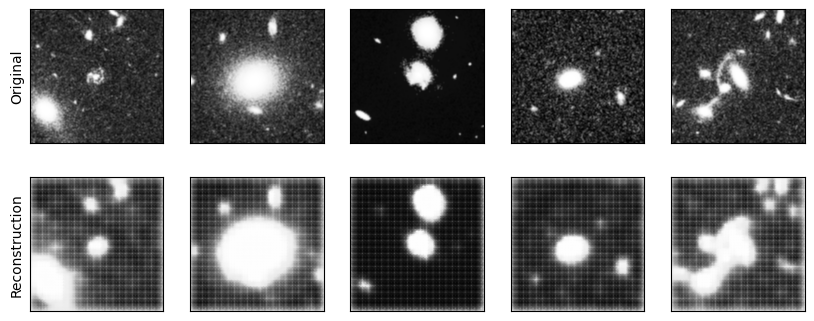

In [10]:
plt.figure(figsize=(10, 4))
for idx in range(5):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(dataset[idx][0][0].numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Original" if idx == 0 else None)
    plt.subplot(2, 5, idx + 6)
    plt.imshow(model(dataset[idx][0].unsqueeze(0))[0, 0].detach().numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Reconstruction" if idx == 0 else None)

Train an MLP classifier on top of the features extracted by auto-encoder.

In [11]:
clf = nn.Sequential(
    nn.Linear(16 * 20 * 20, 512),
    nn.GELU(),
    nn.Linear(512, 2)
)

lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 10
best_score = 0
for epoch in range(n_epochs):
    # train
    clf.train()
    for X, y in tqdm(train_loader):
        X = model.encoder(X).view(-1, 6400)
        loss = lossfn(clf(X), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # validation
    clf.eval()
    auroc = AUROC(task='multiclass', num_classes=2)
    for X, y in tqdm(val_loader):
        X = model.encoder(X).view(-1, 6400)
        auroc.update(clf(X), y)
    score = auroc.compute()
    print(f'Epoch {epoch + 1} - AUROC (validation) {score}')
    if score > best_score:
        best_score = score
        torch.save(clf.state_dict(), 'model-ae-clf.pth')
        
clf.load_state_dict(torch.load('model-ae-clf.pth'))

100%|██████████| 3/3 [00:00<00:00, 30.38it/s]


Epoch 1 - AUROC (validation) 0.7277777194976807


100%|██████████| 3/3 [00:00<00:00, 25.52it/s]


Epoch 2 - AUROC (validation) 0.7388888597488403


100%|██████████| 3/3 [00:00<00:00, 33.24it/s]


Epoch 3 - AUROC (validation) 0.605555534362793


100%|██████████| 3/3 [00:00<00:00, 31.65it/s]


Epoch 4 - AUROC (validation) 0.519444465637207


100%|██████████| 3/3 [00:00<00:00, 32.74it/s]


Epoch 5 - AUROC (validation) 0.7833333015441895


100%|██████████| 3/3 [00:00<00:00, 32.40it/s]


Epoch 6 - AUROC (validation) 0.6499999761581421


100%|██████████| 3/3 [00:00<00:00, 32.85it/s]


Epoch 7 - AUROC (validation) 0.6833332777023315


100%|██████████| 3/3 [00:00<00:00, 35.28it/s]


Epoch 8 - AUROC (validation) 0.7833333015441895


100%|██████████| 3/3 [00:00<00:00, 31.53it/s]


Epoch 9 - AUROC (validation) 0.6833333373069763


100%|██████████| 3/3 [00:00<00:00, 33.87it/s]

Epoch 10 - AUROC (validation) 0.7388889193534851


<All keys matched successfully>

## Metrics - AutoEncoder

Calculate AUROC metric for train/validation datasets.

In [12]:
auroc = AUROC(task='multiclass', num_classes=2)
for X, y in tqdm(train_loader):
    X = model.encoder(X).view(-1, 6400)
    auroc.update(clf(X), y)
print(f'AUROC (train): {auroc.compute()}')

100%|██████████| 25/25 [00:00<00:00, 29.13it/s]

AUROC (train): 0.8093225955963135


In [13]:
auroc = AUROC(task='multiclass', num_classes=2)
for X, y in tqdm(val_loader):
    X = model.encoder(X).view(-1, 6400)
    auroc.update(clf(X), y)
print(f'AUROC (validation): {auroc.compute()}')

100%|██████████| 3/3 [00:00<00:00, 33.62it/s]

AUROC (validation): 0.7833333015441895


Plot the ROC curve for the validation dataset.

100%|██████████| 3/3 [00:00<00:00, 32.59it/s]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MulticlassROC'}, xlabel='False positive rate', ylabel='True positive rate'>)

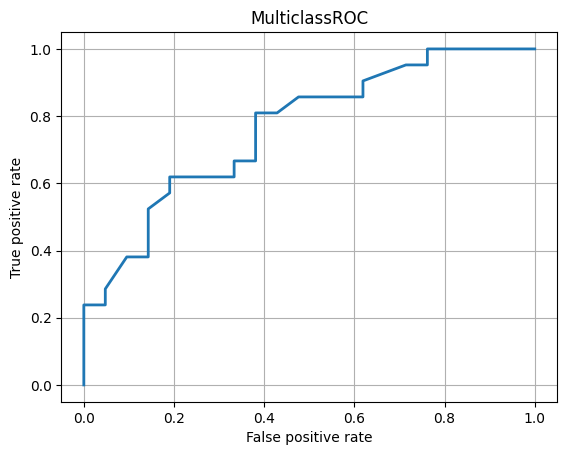

In [14]:
roc = ROC(task='multiclass', num_classes=2, average='micro')
for X, y in tqdm(val_loader):
    X = model.encoder(X).view(-1, 6400)
    roc.update(clf(X), y)
roc.plot(roc.compute())

## Model Training - SimCLR

Despite being straightforward, auto-encoder is not necessarily the best SSL technique.

In this section, we are going to explore using contrastive learning for self-supervised representation learning. In particular, we are going to implement SimCLR [1] for contrastive learning.

[1]: Chen, T., Kornblith, S., Norouzi, M. &amp; Hinton, G.. (2020). A Simple Framework for Contrastive Learning of Visual Representations. <i>Proceedings of the 37th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 119:1597-1607 Available from https://proceedings.mlr.press/v119/chen20j.html.

In [15]:
dataset = LenseImageDataset('real_hst', transform=T.RandomEqualize(1.0))
train_set, val_set = random_split(dataset, [.9, .1])
train_loader  = DataLoader(train_set,  batch_size=8, shuffle=True)
val_loader    = DataLoader(val_set,    batch_size=8, shuffle=False)

For each image in the dataset, we construct two contrastive views by randomly applying image augmentations.

In [16]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset: Dataset) -> None:
        self.dataset = dataset
        self.transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomResizedCrop(size=(334, 334), antialias=True),
            T.GaussianBlur(kernel_size=5, sigma=(0.01, 2)),
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)
        ])
        self.n_views = 2
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, idx: int) -> Tuple[Tuple[Tensor], int]:
        x, y = self.dataset[idx]
        x = tuple(self.transform(x) for _ in range(self.n_views))
        return x, y

In [17]:
contra_set = ContrastiveDataset(train_set)
contra_loader = DataLoader(contra_set, batch_size=8, shuffle=True)

Visualize contrastive views for several images in the dataset.

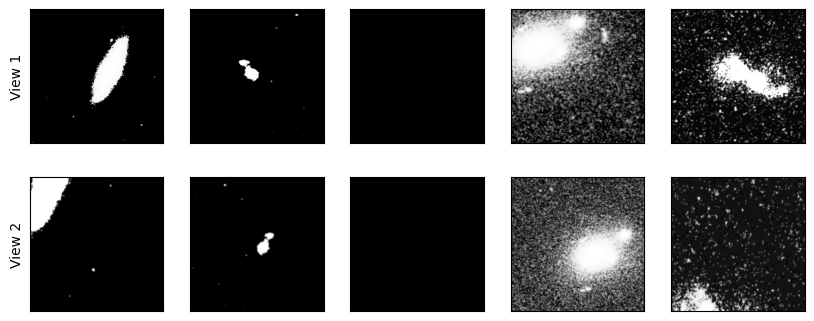

In [18]:
plt.figure(figsize=(10, 4))
for idx in range(5):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(contra_set[idx][0][0][0].numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("View 1" if idx == 0 else None)
    plt.subplot(2, 5, idx + 6)
    plt.imshow(contra_set[idx][0][1][0].numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("View 2" if idx == 0 else None)

Define the contrastive loss, where input $X$ is an $N\times C\times H\times W$ tensor with $N=$ `batch_size` $\times$ `n_views`.

In [19]:
class InfoNCELoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.tao = 0.07
        
    def forward(self, X: Tensor) -> float:
        N = X.shape[0]
        # cosine similarity matrix
        sim = F.cosine_similarity(X[:, None], X[None, :], dim=-1)
        # mask out self-similarity
        mask = torch.eye(N, dtype=torch.bool).to(X.device)
        sim[mask] = -1e16
        # mask for positive contrastive pair (i, batch_size + i)
        positives = mask.roll(shifts=N // 2, dims=0)
        # calculate negative log likelihood
        sim /= self.tao
        nll = -sim[positives] + torch.logsumexp(sim, dim=-1)
        return nll.mean()

Train a ResNet-18 with contrastive loss.

In [20]:
model = timm.create_model('resnet18', in_chans=1, num_classes=2048)
model.fc = nn.Sequential(
    model.fc,
    nn.GELU(),
    nn.Linear(2048, 512)
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

lossfn = InfoNCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    losses = []
    for X, _ in tqdm(contra_loader):
        X = torch.cat(X, dim=0).to(device)
        loss = lossfn(model(X))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch {epoch + 1} - Contrastive Loss (train) {np.mean(losses)}')

torch.save(model.state_dict(), 'model-simclr.pth')

100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Epoch 1 - Contrastive Loss (train) 1.9743426465988159


100%|██████████| 25/25 [00:02<00:00, 11.48it/s]


Epoch 2 - Contrastive Loss (train) 1.857949242591858


100%|██████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch 3 - Contrastive Loss (train) 1.8155359268188476


100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch 4 - Contrastive Loss (train) 1.6936024665832519


100%|██████████| 25/25 [00:02<00:00, 11.14it/s]


Epoch 5 - Contrastive Loss (train) 1.7528347492218017


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


Epoch 6 - Contrastive Loss (train) 1.6892613410949706


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch 7 - Contrastive Loss (train) 1.73912456035614


100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


Epoch 8 - Contrastive Loss (train) 1.6621697473526


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch 9 - Contrastive Loss (train) 1.6322586011886597


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch 10 - Contrastive Loss (train) 1.764534068107605


100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch 11 - Contrastive Loss (train) 1.6370263528823852


100%|██████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch 12 - Contrastive Loss (train) 1.5706916379928588


100%|██████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch 13 - Contrastive Loss (train) 1.6854990816116333


100%|██████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch 14 - Contrastive Loss (train) 1.5976452493667603


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


Epoch 15 - Contrastive Loss (train) 1.6123069524765015


100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch 16 - Contrastive Loss (train) 1.4743289375305175


100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch 17 - Contrastive Loss (train) 1.5261022925376893


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


Epoch 18 - Contrastive Loss (train) 1.6596196651458741


100%|██████████| 25/25 [00:02<00:00, 11.20it/s]


Epoch 19 - Contrastive Loss (train) 1.537705078125


100%|██████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch 20 - Contrastive Loss (train) 1.592971806526184


100%|██████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch 21 - Contrastive Loss (train) 1.4250521516799928


100%|██████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch 22 - Contrastive Loss (train) 1.5504159140586853


100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch 23 - Contrastive Loss (train) 1.6391100072860718


100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch 24 - Contrastive Loss (train) 1.5830096340179443


100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


Epoch 25 - Contrastive Loss (train) 1.6026002287864685


100%|██████████| 25/25 [00:02<00:00, 11.50it/s]


Epoch 26 - Contrastive Loss (train) 1.75581636428833


100%|██████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch 27 - Contrastive Loss (train) 1.4702219343185425


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


Epoch 28 - Contrastive Loss (train) 1.6285020232200622


100%|██████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch 29 - Contrastive Loss (train) 1.5852889108657837


100%|██████████| 25/25 [00:02<00:00, 11.02it/s]


Epoch 30 - Contrastive Loss (train) 1.4478219056129455


100%|██████████| 25/25 [00:02<00:00, 11.05it/s]


Epoch 31 - Contrastive Loss (train) 1.5347388768196106


100%|██████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch 32 - Contrastive Loss (train) 1.4000572514533998


100%|██████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch 33 - Contrastive Loss (train) 1.472143487930298


100%|██████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch 34 - Contrastive Loss (train) 1.4927091193199158


100%|██████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch 35 - Contrastive Loss (train) 1.5260349917411804


100%|██████████| 25/25 [00:02<00:00, 11.55it/s]


Epoch 36 - Contrastive Loss (train) 1.4209252095222473


100%|██████████| 25/25 [00:02<00:00, 11.03it/s]


Epoch 37 - Contrastive Loss (train) 1.468370704650879


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


Epoch 38 - Contrastive Loss (train) 1.387869544029236


100%|██████████| 25/25 [00:02<00:00, 10.81it/s]


Epoch 39 - Contrastive Loss (train) 1.629228801727295


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch 40 - Contrastive Loss (train) 1.6150360870361329


100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


Epoch 41 - Contrastive Loss (train) 1.5357908511161804


100%|██████████| 25/25 [00:02<00:00, 10.68it/s]


Epoch 42 - Contrastive Loss (train) 1.4383332014083863


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


Epoch 43 - Contrastive Loss (train) 1.4985182690620422


100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


Epoch 44 - Contrastive Loss (train) 1.5329174327850341


100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


Epoch 45 - Contrastive Loss (train) 1.427051076889038


100%|██████████| 25/25 [00:02<00:00, 10.21it/s]


Epoch 46 - Contrastive Loss (train) 1.390434582233429


100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch 47 - Contrastive Loss (train) 1.453421585559845


100%|██████████| 25/25 [00:02<00:00, 10.14it/s]


Epoch 48 - Contrastive Loss (train) 1.4917187309265136


100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


Epoch 49 - Contrastive Loss (train) 1.5390870189666748


100%|██████████| 25/25 [00:02<00:00, 10.86it/s]

Epoch 50 - Contrastive Loss (train) 1.4304576659202575


Train an MLP classifier on top of the features extracted by contrastive ResNet-18.

In [21]:
clf = nn.Sequential(
    nn.Linear(512, 64),
    nn.GELU(),
    nn.Linear(64, 2)
)

lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 10
best_score = 0
for epoch in range(n_epochs):
    # train
    clf.train()
    for X, y in tqdm(train_loader):
        X = model(X.to(device)).cpu()
        loss = lossfn(clf(X), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # validation
    clf.eval()
    auroc = AUROC(task='multiclass', num_classes=2)
    for X, y in tqdm(val_loader):
        X = model(X.to(device)).cpu()
        auroc.update(clf(X), y)
    score = auroc.compute()
    print(f'Epoch {epoch + 1} - AUROC (validation) {score}')
    if score > best_score:
        best_score = score
        torch.save(clf.state_dict(), 'model-simclr-clf.pth')

clf.load_state_dict(torch.load('model-simclr-clf.pth'))

100%|██████████| 3/3 [00:00<00:00, 32.93it/s]


Epoch 1 - AUROC (validation) 0.7631579637527466


100%|██████████| 3/3 [00:00<00:00, 41.66it/s]


Epoch 2 - AUROC (validation) 0.7631579041481018


100%|██████████| 3/3 [00:00<00:00, 40.13it/s]


Epoch 3 - AUROC (validation) 0.7631579637527466


100%|██████████| 3/3 [00:00<00:00, 35.55it/s]


Epoch 4 - AUROC (validation) 0.7631579637527466


100%|██████████| 3/3 [00:00<00:00, 37.44it/s]


Epoch 5 - AUROC (validation) 0.736842155456543


100%|██████████| 3/3 [00:00<00:00, 40.89it/s]


Epoch 6 - AUROC (validation) 0.7631579637527466


100%|██████████| 3/3 [00:00<00:00, 37.64it/s]


Epoch 7 - AUROC (validation) 0.7631579637527466


100%|██████████| 3/3 [00:00<00:00, 36.17it/s]


Epoch 8 - AUROC (validation) 0.736842155456543


100%|██████████| 3/3 [00:00<00:00, 40.06it/s]


Epoch 9 - AUROC (validation) 0.736842155456543


100%|██████████| 3/3 [00:00<00:00, 41.23it/s]

Epoch 10 - AUROC (validation) 0.736842155456543


<All keys matched successfully>

## Metrics - SimCLR

Calculate AUROC metric for train/validation datasets.

In [22]:
auroc = AUROC(task='multiclass', num_classes=2)
for X, y in tqdm(train_loader):
    X = model(X.to(device)).cpu()
    auroc.update(clf(X), y)
print(f'AUROC (train): {auroc.compute()}')

100%|██████████| 25/25 [00:00<00:00, 37.27it/s]

AUROC (train): 0.675212562084198


In [23]:
auroc = AUROC(task='multiclass', num_classes=2)
for X, y in tqdm(val_loader):
    X = model(X.to(device)).cpu()
    auroc.update(clf(X), y)
print(f'AUROC (validation): {auroc.compute()}')

100%|██████████| 3/3 [00:00<00:00, 40.45it/s]

AUROC (validation): 0.7631579637527466


Plot the ROC curve for the validation dataset.

100%|██████████| 3/3 [00:00<00:00, 40.76it/s]


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MulticlassROC'}, xlabel='False positive rate', ylabel='True positive rate'>)

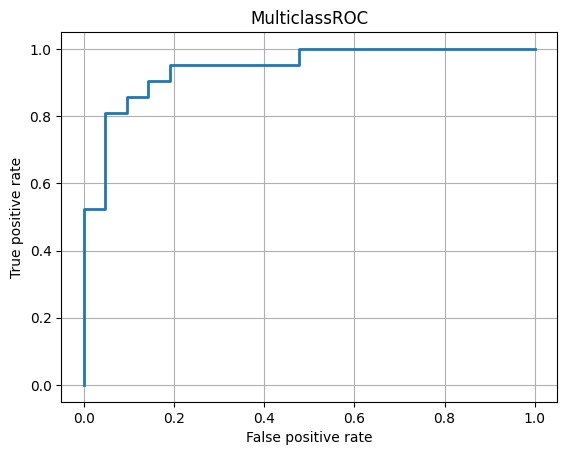

In [24]:
roc = ROC(task='multiclass', num_classes=2, average='micro')
for X, y in tqdm(val_loader):
    X = model(X.to(device)).cpu()
    roc.update(clf(X), y)
roc.plot(roc.compute())